In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import random

In [2]:
# Importing birth rate data
birthData = pd.read_csv("Datasets/Birth_Rate_clean.csv")
birthData.tail()

,Data Series,2022 Dec,2022 Nov,2022 Oct,2022 Sep,2022 Aug,2022 Jul,2022 Jun,2022 May,2022 Apr,...,1960 Oct,1960 Sep,1960 Aug,1960 Jul,1960 Jun,1960 May,1960 Apr,1960 Mar,1960 Feb,1960 Jan
10,Total Female Live-Births By Ethnic Group,1422,1452,1506,1539,1458,1426,1379,1420,1306,...,2754,2478,2583,2547,2451,2586,2388,2396,2166,2360
11,Malays,308,323,333,363,319,287,330,320,331,...,474,441,472,426,413,432,393,418,402,394
12,Chinese,825,797,856,869,799,831,748,831,705,...,2013,1754,1856,1848,1794,1910,1776,1756,1523,1701
13,Indians,158,182,161,163,150,173,155,142,154,...,218,243,200,218,210,196,179,178,192,227
14,Other Ethnic Groups,131,150,156,144,190,135,146,127,116,...,49,40,55,55,34,48,40,44,49,38


In [3]:
# Data cleaning
# Update index name
birthData = birthData.rename(columns = {'Data Series':'Date'})
birthData.set_index('Date',inplace=True)
birthData = birthData.rename(columns=lambda x: x.strip())
birthData.columns = pd.DatetimeIndex(birthData.columns).to_period('M')
# birthData.head()

# Switch rows and columns (Tranpose)
birthData = birthData.T
birthData = birthData.rename(columns=lambda x: x.strip())
birthData = birthData.sort_index()
birthData.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 756 entries, 1960-01 to 2022-12
Freq: M
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Total Live-Births By Ethnic Group         756 non-null    int64
 1   Malays                                    756 non-null    int64
 2   Chinese                                   756 non-null    int64
 3   Indians                                   756 non-null    int64
 4   Other Ethnic Groups                       756 non-null    int64
 5   Total Male Live-Births By Ethnic Group    756 non-null    int64
 6   Malays                                    756 non-null    int64
 7   Chinese                                   756 non-null    int64
 8   Indians                                   756 non-null    int64
 9   Other Ethnic Groups                       756 non-null    int64
 10  Total Female Live-Births By Ethnic Group  7

<AxesSubplot:>

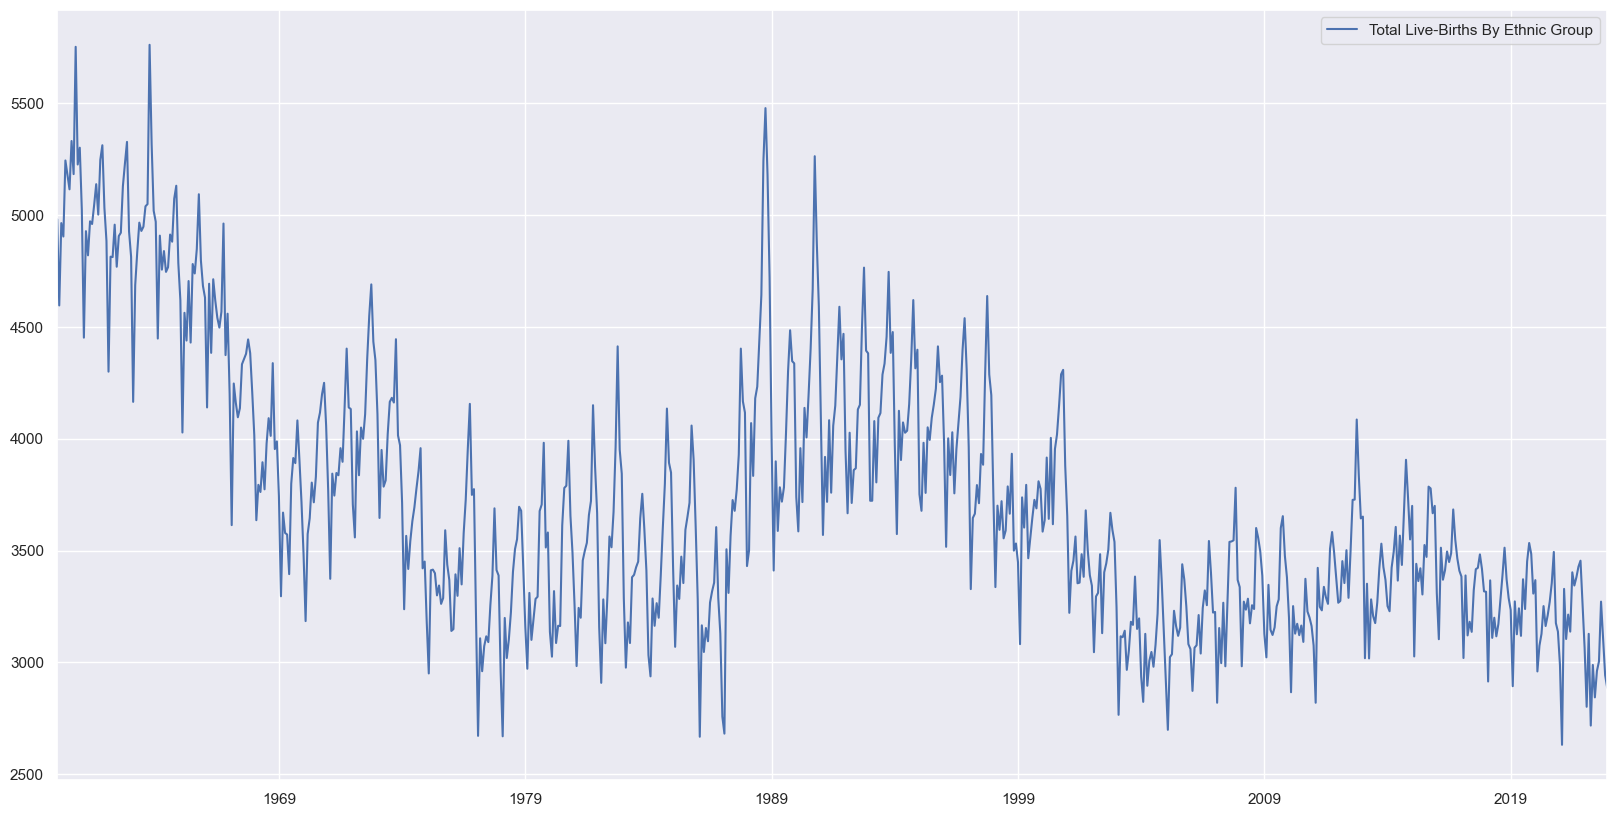

In [4]:
babies = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])

babies.head()
babies = babies.astype('int64')
babies.plot(figsize=(20, 10))

## Variable: Housing Prices
- Dataset is found across multiple csv files, so used `concat` to put all into 1 dataframe
- Standardized the date to `YYYY-MM` following the date format for the birth count dataset
- Standardized the naming convention for `flat_type` and `flat_model`
    - Adding a hypen rather than space
    - Change to full uppercase
- Ignoring `flat_model`, using `flat_type` instead
- Remove outliers for each `flat_type`
- As there are multiple `resale_price` for the same `flat_type` on the same `Date`, getting average of those rounded to 2 decimal places

In [5]:
# Variable: Housing Prices
houseResale = pd.concat(map(pd.read_csv, ['Datasets/Resale Flat Prices/Resale Approval Date 1990-1999.csv', 'Datasets/Resale Flat Prices/Resale Approval Date 2000-Feb-2012.csv', 'Datasets/Resale Flat Prices/Resale Registration Date Mar-2012-Dec-2014.csv', 'Datasets/Resale Flat Prices/Resale Registration Date Jan-2015-Dec-2016.csv', 'Datasets/Resale Flat Prices/Resale Registration Date Jan-2017-Onwards.csv']))
houseResale = houseResale.rename(columns = {'month':'Date'})
birthData = birthData.rename(columns=lambda x: x.strip())
houseResale['Date'] = pd.to_datetime(houseResale['Date'])
houseResale['Date'] = houseResale['Date'].dt.strftime('%Y-%m')

# Standardizing flat_type and flat_models
houseResale['flat_type'] = ['MULTI-GENERATION' if x=='MULTI GENERATION' else x for x in houseResale['flat_type']]
houseResale['flat_model'] = [x.upper() for x in houseResale['flat_model']]

tempFrame = houseResale[['Date', 'flat_type', 'flat_model', 'resale_price']].copy()

# Removing outliers
flatType = ['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
separateType = []

for flat in flatType:
    temp = tempFrame.loc[tempFrame['flat_type'] == flat]
    Q3 = temp['resale_price'].quantile(0.25)
    Q1 = temp['resale_price'].quantile(0.75)
    IQR = Q1-Q3
    separateType.append(temp[~((temp['resale_price'] < (Q1 - 1.5*IQR)) | (temp['resale_price'] > (Q3 + 1.5*IQR)))])

# Ignore flat_model
tempFrame = pd.concat(separateType).reset_index().drop(['index'], axis=1)
tempFrame = tempFrame.groupby(['Date', 'flat_type'])['resale_price'].mean().round(2).to_frame()
tempFrame = tempFrame.round(2)
tempFrame = tempFrame.rename(columns={'resale_price': 'avg_resale'}).reset_index()

In [6]:
tempFrame.head()

,Date,flat_type,avg_resale
0,1990-01,3 ROOM,77980.00
1,1990-01,4 ROOM,149500.00
2,1990-02,3 ROOM,75690.91
3,1990-02,4 ROOM,152533.33
4,1990-03,3 ROOM,82060.00


In [7]:
# Getting avg_resale dataframe for specific flat_type
temp1R = tempFrame.loc[tempFrame['flat_type'] == '1 ROOM']
temp1R = temp1R.set_index('Date')
temp1R.index = pd.to_datetime(temp1R.index).to_period('M')
temp1R['prev_avg'] = temp1R['avg_resale'].shift(1)

temp3R = tempFrame.loc[tempFrame['flat_type'] == '3 ROOM']
temp3R = temp3R.set_index('Date')
temp3R.index = pd.to_datetime(temp3R.index).to_period('M')
temp3R['prev_avg'] = temp3R['avg_resale'].shift(1)

temp4R = tempFrame.loc[tempFrame['flat_type'] == '4 ROOM']
temp4R = temp4R.set_index('Date')
temp4R.index = pd.to_datetime(temp4R.index).to_period('M')
temp4R['prev_avg'] = temp4R['avg_resale'].shift(1)

temp5R = tempFrame.loc[tempFrame['flat_type'] == '5 ROOM']
temp5R = temp5R.set_index('Date')
temp5R.index = pd.to_datetime(temp5R.index).to_period('M')
temp5R['prev_avg'] = temp5R['avg_resale'].shift(1)

tempEx = tempFrame.loc[tempFrame['flat_type'] == 'EXECUTIVE']
tempEx = tempEx.set_index('Date')
tempEx.index = pd.to_datetime(tempEx.index).to_period('M')
tempEx['prev_avg'] = tempEx['avg_resale'].shift(1)

tempMg = tempFrame.loc[tempFrame['flat_type'] == 'MULTI-GENERATION']
tempMg = tempMg.set_index('Date')
tempMg.index = pd.to_datetime(tempMg.index).to_period('M')
tempMg['prev_avg'] = tempMg['avg_resale'].shift(1)

print('Count by Room Type')
print('1 Room:  ', len(temp1R))
print('3 Room:  ', len(temp3R))
print('4 Room:  ', len(temp4R))
print('5 Room:  ', len(temp5R))
print('Ex Room: ', len(tempEx))
print('Mg Room: ', len(tempMg))

Count by Room Type
1 Room:   153
3 Room:   399
4 Room:   396
5 Room:   378
Ex Room:  366
Mg Room:  202


<AxesSubplot:>

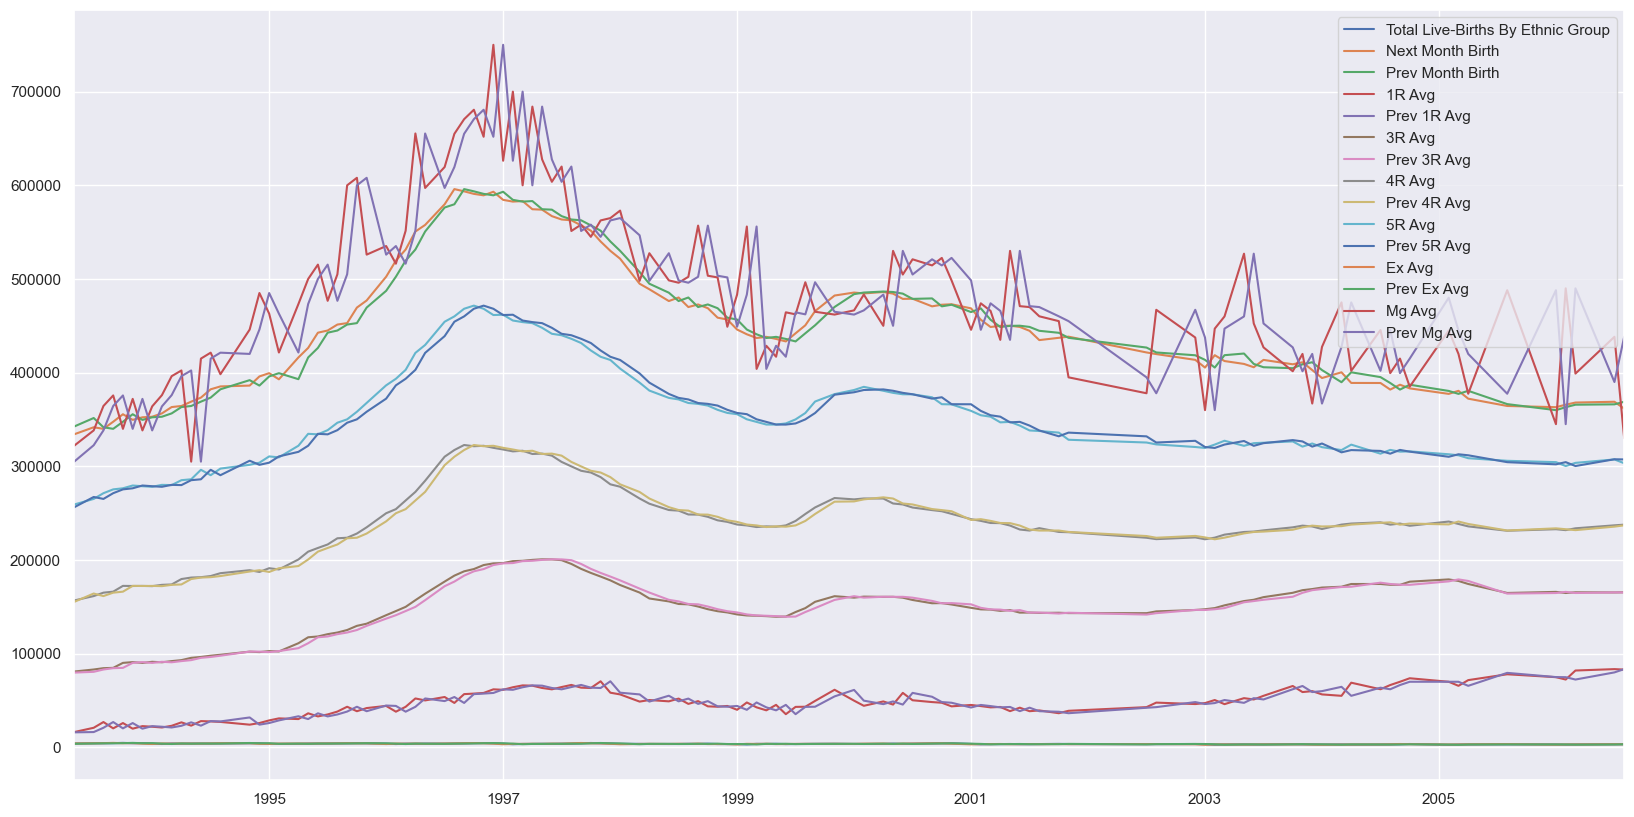

In [8]:
housingBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
housingBaby['Next Month Birth'] = housingBaby['Total Live-Births By Ethnic Group'].shift(-1)
housingBaby['Prev Month Birth'] = housingBaby['Total Live-Births By Ethnic Group'].shift(1)

# Dropping NaN rows (First and Last Row)
housingBaby = housingBaby.dropna()

housing1R = housingBaby.join(temp1R[['avg_resale', 'prev_avg']], how='inner').rename(columns={'avg_resale': '1R Avg', 'prev_avg': 'Prev 1R Avg'})
housing3R = housingBaby.join(temp3R[['avg_resale', 'prev_avg']], how='inner').rename(columns={'avg_resale': '3R Avg', 'prev_avg': 'Prev 3R Avg'})
housing4R = housingBaby.join(temp4R[['avg_resale', 'prev_avg']], how='inner').rename(columns={'avg_resale': '4R Avg', 'prev_avg': 'Prev 4R Avg'})
housing5R = housingBaby.join(temp5R[['avg_resale', 'prev_avg']], how='inner').rename(columns={'avg_resale': '5R Avg', 'prev_avg': 'Prev 5R Avg'})
housingEx = housingBaby.join(tempEx[['avg_resale', 'prev_avg']], how='inner').rename(columns={'avg_resale': 'Ex Avg', 'prev_avg': 'Prev Ex Avg'})
housingMg = housingBaby.join(tempMg[['avg_resale', 'prev_avg']], how='inner').rename(columns={'avg_resale': 'Mg Avg', 'prev_avg': 'Prev Mg Avg'})
housingMerge = pd.concat([housing1R, housing3R, housing4R, housing5R, housingEx, housingMg], axis=1, join='inner')
housingMerge = housingMerge.loc[:,~housingMerge.columns.duplicated(keep='first')]
housingMerge.plot(figsize=(20, 10))

In [9]:
housingMerge.info()
housingMerge.loc[:, ~housingMerge.columns.isin(['Prev 1R Avg', 'Prev 3R Avg', 'Prev 4R Avg', 'Prev 5R Avg', 'Prev Ex Avg', 'Prev Mg Avg'])].corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 117 entries, 1993-05 to 2006-08
Freq: M
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  117 non-null    int64  
 1   Next Month Birth                   117 non-null    float64
 2   Prev Month Birth                   117 non-null    float64
 3   1R Avg                             117 non-null    float64
 4   Prev 1R Avg                        117 non-null    float64
 5   3R Avg                             117 non-null    float64
 6   Prev 3R Avg                        117 non-null    float64
 7   4R Avg                             117 non-null    float64
 8   Prev 4R Avg                        117 non-null    float64
 9   5R Avg                             117 non-null    float64
 10  Prev 5R Avg                        117 non-null    float64
 11  Ex Avg                             117 

,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,1R Avg,3R Avg,4R Avg,5R Avg,Ex Avg,Mg Avg
Total Live-Births By Ethnic Group,1.000000,0.849218,0.848082,-0.472296,-0.332959,-0.020290,0.230668,0.286764,0.250351
Next Month Birth,0.849218,1.000000,0.763069,-0.439507,-0.331712,-0.024035,0.217193,0.265917,0.267820
Prev Month Birth,0.848082,0.763069,1.000000,-0.492476,-0.353167,-0.038297,0.220302,0.279113,0.276994
1R Avg,-0.472296,-0.439507,-0.492476,1.000000,0.872786,0.661126,0.409396,0.318346,0.310646
3R Avg,-0.332959,-0.331712,-0.353167,0.872786,1.000000,0.908315,0.729726,0.662460,0.591258
4R Avg,-0.020290,-0.024035,-0.038297,0.661126,0.908315,1.000000,0.943722,0.904494,0.806424
5R Avg,0.230668,0.217193,0.220302,0.409396,0.729726,0.943722,1.000000,0.991013,0.889156
Ex Avg,0.286764,0.265917,0.279113,0.318346,0.662460,0.904494,0.991013,1.000000,0.890597
Mg Avg,0.250351,0.267820,0.276994,0.310646,0.591258,0.806424,0.889156,0.890597,1.000000


## Analysis
- Too few entries, likely due to the intersection of the different housing types
- See if there is a way to remove some of these columns, to get more data points
- `1R Avg` does not have a good enough correlation with any of the averages such that it can be removed
- After some research, it seems that 3R, 4R and 5R are the most common amongst young couples/families. [Source](https://www.mynicehome.gov.sg/hdb-how-to/buy-your-flat/a-guide-to-hdb-bto-flat-types/)
- Hence, updating dataframe to include only 3R, 4R and 5R
    - Fortunately, they have the most data points among the averages

In [10]:
housingUpdate = pd.concat([housing3R, housing4R, housing5R], axis=1, join='inner')
housingUpdate = housingUpdate.loc[:,~housingUpdate.columns.duplicated(keep='first')]
housingUpdate.info()
housingUpdate.loc[:, ~housingUpdate.columns.isin(['Prev 3R Avg', 'Prev 4R Avg', 'Prev 5R Avg'])].corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 373 entries, 1991-07 to 2022-11
Freq: M
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  373 non-null    int64  
 1   Next Month Birth                   373 non-null    float64
 2   Prev Month Birth                   373 non-null    float64
 3   3R Avg                             373 non-null    float64
 4   Prev 3R Avg                        373 non-null    float64
 5   4R Avg                             373 non-null    float64
 6   Prev 4R Avg                        373 non-null    float64
 7   5R Avg                             373 non-null    float64
 8   Prev 5R Avg                        373 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 29.1 KB


,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,3R Avg,4R Avg,5R Avg
Total Live-Births By Ethnic Group,1.000000,0.849316,0.845988,-0.508727,-0.434129,-0.311686
Next Month Birth,0.849316,1.000000,0.790944,-0.510863,-0.437168,-0.318515
Prev Month Birth,0.845988,0.790944,1.000000,-0.504473,-0.429592,-0.301726
3R Avg,-0.508727,-0.510863,-0.504473,1.000000,0.984329,0.917998
4R Avg,-0.434129,-0.437168,-0.429592,0.984329,1.000000,0.969291
5R Avg,-0.311686,-0.318515,-0.301726,0.917998,0.969291,1.000000


<AxesSubplot:>

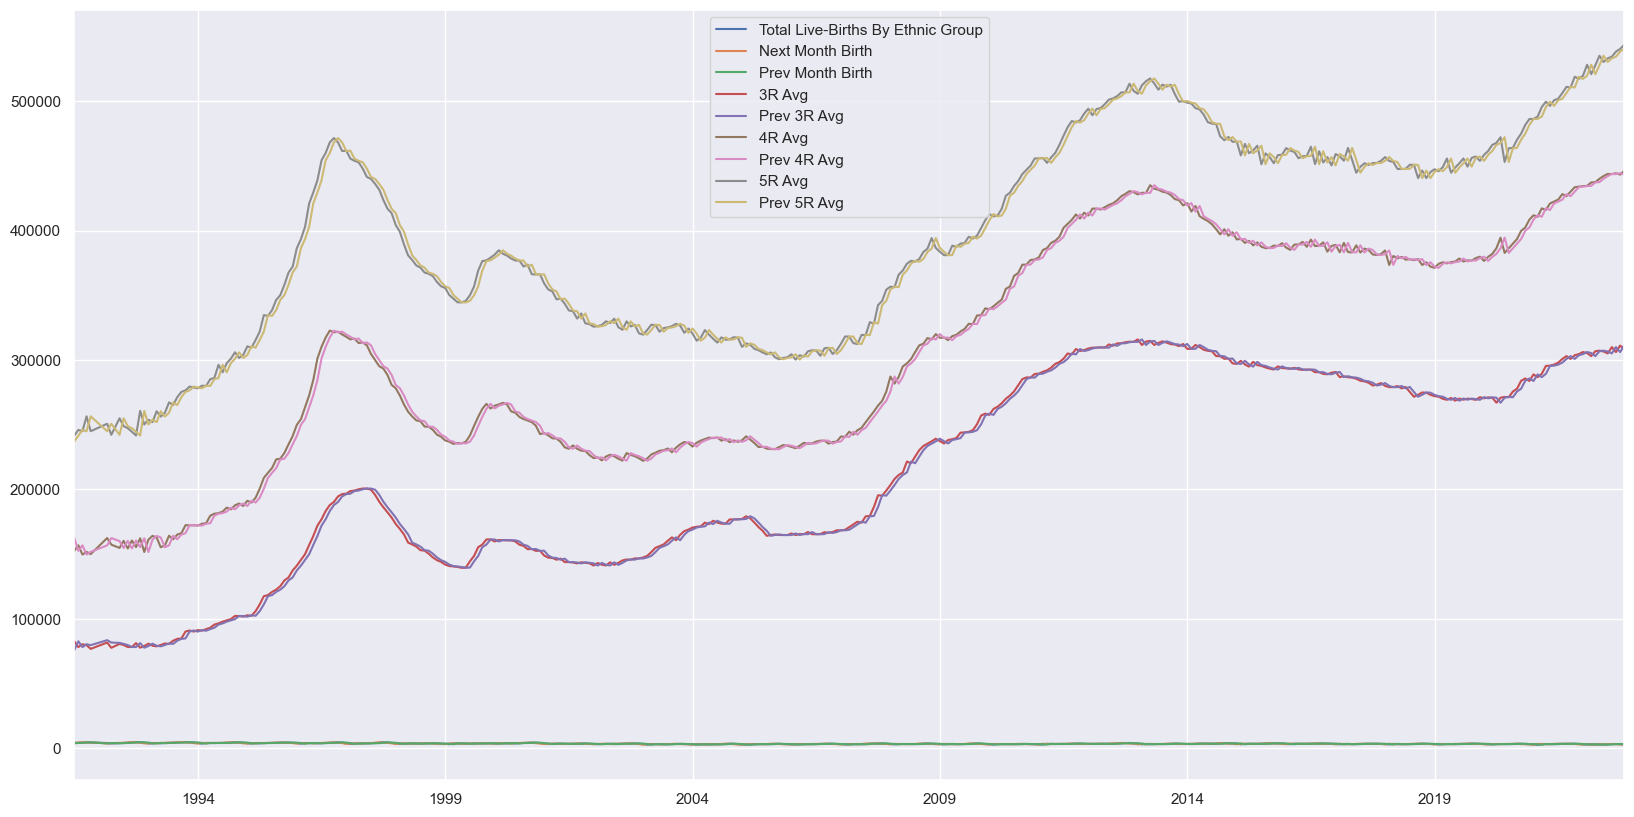

In [11]:
housingUpdate.plot(figsize=(20, 10))

## Classification: Random Forest vs Logistic Regression
- Goal: From the available variables this month, predict the rise/fall of the next month's birth rate
- Available Data:
    - Current/Prev Month Birth Count
    - 3-Room/4-Room/5-Room Average
    
## Performance Evaluation Technique: K-Fold vs Leave-One-Out
- Leave-one-out too computational expensive, going for K-Fold instead
- Since dataset is small (About 300+ data points), use a smaller fold number (3)
- This gives about 100+ data points for each fold

## Classification Model Performance Metrics
- Accuracy:  Number of correct predictions
- Precision: Proportion of true positives out of all positive predictions
- Recall:    Proportion of true positives out of all actual positive cases
- F1 Score:  Harmonic mean of precision and recall

In [12]:
# Step 1: Create binary target variable
housingUpdate['Rise-Fall'] = (housingUpdate['Total Live-Births By Ethnic Group'] > housingUpdate['Next Month Birth']).astype(int)

In [46]:
resultsRf = []

# Defining number of folds for cross-validation
num_folds = 3

for i in range(100):
    # Defining random seed
    seed = random.randint(0, 100000)
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = housingUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', '3R Avg', 'Prev 3R Avg', 
                       '4R Avg', 'Prev 4R Avg', '5R Avg', 'Prev 5R Avg']]

    # Step 2.2: Response
    y = housingUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

# Sort results by F1 score in descending order
resultsRf.sort(key=lambda x: x[7], reverse=True)

In [47]:
resultsLr = []

for i in range(5):
    seed = resultsRf[i][0]
    kResLr = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        lr = LogisticRegression(max_iter=1000, solver='liblinear')
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        
        accuracy_lr = accuracy_score(y_test, y_pred_lr)
        precision_lr = precision_score(y_test, y_pred_lr)
        recall_lr = recall_score(y_test, y_pred_lr)
        f1_lr = f1_score(y_test, y_pred_lr)
        kResLr.append((fold, accuracy_lr, precision_lr, recall_lr, f1_lr))
        
    acc_mean_lr, acc_std_lr = np.mean([r[1] for r in kResLr]), np.std([r[1] for r in kResLr])
    prec_mean_lr, prec_std_lr = np.mean([r[2] for r in kResLr]), np.std([r[2] for r in kResLr])
    rec_mean_lr, rec_std_lr = np.mean([r[3] for r in kResLr]), np.std([r[3] for r in kResLr])
    f1_mean_lr, f1_std_lr = np.mean([r[4] for r in kResLr]), np.std([r[4] for r in kResLr])   
    resultsLr.append((seed, acc_mean_lr, acc_std_lr, prec_mean_lr, prec_std_lr, rec_mean_lr, rec_std_lr, f1_mean_lr, f1_std_lr))

In [48]:
topResultsRf = resultsRf[:5]

for i in range(5):
    print('----------------------------------------------')
    print(f"Random state {topResultsRf[i][0]}:")
    print(f'Accuracy  = {topResultsRf[i][1]:.4f} +/- {topResultsRf[i][2]:.4f}  vs  {resultsLr[i][1]:.4f} +/- {resultsLr[i][2]:.4f}')
    print(f'Precision = {topResultsRf[i][3]:.4f} +/- {topResultsRf[i][4]:.4f}  vs  {resultsLr[i][3]:.4f} +/- {resultsLr[i][4]:.4f}')
    print(f'Recall    = {topResultsRf[i][5]:.4f} +/- {topResultsRf[i][6]:.4f}  vs  {resultsLr[i][5]:.4f} +/- {resultsLr[i][6]:.4f}')
    print(f'F1 score  = {topResultsRf[i][7]:.4f} +/- {topResultsRf[i][8]:.4f}  vs  {resultsLr[i][7]:.4f} +/- {resultsLr[i][8]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 24338:
Accuracy  = 0.6460 +/- 0.0313  vs  0.5898 +/- 0.0430
Precision = 0.6311 +/- 0.0619  vs  0.5773 +/- 0.0482
Recall    = 0.6735 +/- 0.0430  vs  0.6009 +/- 0.0954
F1 score  = 0.6474 +/- 0.0109  vs  0.5827 +/- 0.0450
----------------------------------------------
Random state 85040:
Accuracy  = 0.6354 +/- 0.0152  vs  0.5898 +/- 0.0430
Precision = 0.6181 +/- 0.0597  vs  0.5773 +/- 0.0482
Recall    = 0.6574 +/- 0.0527  vs  0.6009 +/- 0.0954
F1 score  = 0.6332 +/- 0.0276  vs  0.5827 +/- 0.0450
----------------------------------------------
Random state 68272:
Accuracy  = 0.6435 +/- 0.0153  vs  0.5898 +/- 0.0430
Precision = 0.6365 +/- 0.0642  vs  0.5773 +/- 0.0482
Recall    = 0.6199 +/- 0.0288  vs  0.6009 +/- 0.0954
F1 score  = 0.6247 +/- 0.0184  vs  0.5827 +/- 0.0450
----------------------------------------------
Random state 84284:
Accuracy  = 0.6327 +/- 0.0145  vs  0.5898 +/- 0.0430
Precision = 0.6224 +/- 0.0553  vs  0.5773 +

In [49]:
print(f'Average Accuracy:  {sum([i[1] for i in topResultsRf])/5:.4f}  vs  {sum([i[1] for i in resultsLr])/5:.4f}')
print(f'Average Precision: {sum([i[3] for i in topResultsRf])/5:.4f}  vs  {sum([i[3] for i in resultsLr])/5:.4f}')
print(f'Average Recall:    {sum([i[5] for i in topResultsRf])/5:.4f}  vs  {sum([i[5] for i in resultsLr])/5:.4f}')
print(f'Average F1 Score:  {sum([i[7] for i in topResultsRf])/5:.4f}  vs  {sum([i[7] for i in resultsLr])/5:.4f}')

Average Accuracy:  0.6386  vs  0.5898
Average Precision: 0.6269  vs  0.5773
Average Recall:    0.6460  vs  0.6009
Average F1 Score:  0.6300  vs  0.5827


## Logistic Regression vs Random Forest
The logistic regression has been constanly doing worse than the random forest, despite using the same seed and after testing with different number of variables

Conclusion: Random forest is the better model in this case

In [50]:
resultsRf2 = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = housingUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth',
                       '3R Avg', '4R Avg', '5R Avg']]

    # Step 2.2: Response
    y = housingUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf2.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

In [51]:
resultsRf3 = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = housingUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth',
                       '3R Avg', 'Prev 3R Avg']]

    # Step 2.2: Response
    y = housingUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf3.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

In [52]:
resultsRf4 = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = housingUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth',
                       '3R Avg']]

    # Step 2.2: Response
    y = housingUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf4.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

In [53]:
print(f'Average Accuracy:  {sum([i[1] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[1] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[1] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[1] for i in resultsRf4])/5:.4f}')
print(f'Average Precision: {sum([i[3] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[3] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[3] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[3] for i in resultsRf4])/5:.4f}')
print(f'Average Recall:    {sum([i[5] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[5] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[5] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[5] for i in resultsRf4])/5:.4f}')
print(f'Average F1 Score:  {sum([i[7] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[7] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[7] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[7] for i in resultsRf4])/5:.4f}')

Average Accuracy:  0.6386        vs  0.6573       vs  0.6391       vs  0.6327
Average Precision: 0.6269        vs  0.6436       vs  0.6253       vs  0.6183
Average Recall:    0.6460        vs  0.6608       vs  0.6438       vs  0.6425
Average F1 Score:  0.6300        vs  0.6477       vs  0.6301       vs  0.6247


## Accuracy
1. Removing previous housing average resale
2. 3R previous and current average resale
3. All
4. Just current 3R average resale

## Precision
1. Removing previous housing average resale
2. All
3. 3R previous and current average resale
4. Just current 3R average resale

## Recall
1. Removing previous housing average resale
2. All
3. 3R previous and current average resale
4. Just current 3R average resale

## F1 Score
1. Removing precious housing average resale
2. 3R previous and current average resale
3. All
4. Just current 3R average resale

## Final Verdict on Variables
Perfomance Ranking:
1. Removing previous housing average resale
2. All
3. 3R previous and current average resale
4. Just current 3R average resale

Conclusion: Keep current 3R, 4R, 5R only

## Bagging Classifier vs Top Model from Random Forest
- Multiple models were trained previously
- Retrain the Random Forest models with the seeds used, but with the entire dataset rather than the K-Fold ones
- Trying out another model which combines the top models trained from the Random Forest (Bagging Classifier)
- Comparing to see if it will give a better model

In [57]:
results = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = housingUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth',
                       '3R Avg', '4R Avg', '5R Avg']]

    # Step 2.2: Response
    y = housingUpdate['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))
    
# results.sort(key=lambda x: x[4], reverse=True)

In [58]:
bagRes = []

for i in range(5):
    seed = resultsRf[i][0]
    
    finalModels = [res[-1] for res in results]
    bc = BaggingClassifier(n_estimators=len(finalModels))

    bc.estimators_ = finalModels

    X = housingUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', '3R Avg', 'Prev 3R Avg', 
                           '4R Avg', 'Prev 4R Avg', '5R Avg', 'Prev 5R Avg']]
    y = housingUpdate['Rise-Fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    bc.fit(X_train, y_train)

    y_pred = bc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    bagRes.append((seed, accuracy, precision, recall, f1, bc))

# results.sort(key=lambda x: x[4], reverse=True)

In [60]:
for i in range(5):
    print('----------------------------------------------')
    print(f"Random state {resultsRf[i][0]}:")
    print(f'Accuracy  = {results[i][1]:.4f}  vs  {bagRes[i][1]:.4f}')
    print(f'Precision = {results[i][2]:.4f}  vs  {bagRes[i][2]:.4f}')
    print(f'Recall    = {results[i][3]:.4f}  vs  {bagRes[i][3]:.4f}')
    print(f'F1 score  = {results[i][4]:.4f}  vs  {bagRes[i][4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 24338:
Accuracy  = 0.6933  vs  0.7200
Precision = 0.7073  vs  0.7436
Recall    = 0.7250  vs  0.7250
F1 score  = 0.7160  vs  0.7342
----------------------------------------------
Random state 85040:
Accuracy  = 0.6400  vs  0.5867
Precision = 0.5385  vs  0.4884
Recall    = 0.7000  vs  0.7000
F1 score  = 0.6087  vs  0.5753
----------------------------------------------
Random state 68272:
Accuracy  = 0.6667  vs  0.5733
Precision = 0.6957  vs  0.6410
Recall    = 0.7442  vs  0.5814
F1 score  = 0.7191  vs  0.6098
----------------------------------------------
Random state 84284:
Accuracy  = 0.6400  vs  0.6267
Precision = 0.7027  vs  0.6750
Recall    = 0.6190  vs  0.6429
F1 score  = 0.6582  vs  0.6585
----------------------------------------------
Random state 42754:
Accuracy  = 0.7200  vs  0.6533
Precision = 0.7059  vs  0.6364
Recall    = 0.6857  vs  0.6000
F1 score  = 0.6957  vs  0.6176
---------------------------------------------

There were some instances where the `Bagging Classifier` performed slightly better than the `Random Forest Classifier`, but the difference in performance does not seem too significant.

There is a larger gap in performance in the times where the `Random Forest Classifier` model did better.

Conclusion: Still `Random Forest Classifier`

## Final Conclusion
- Model: Random Forest Classifier
- Variables: 3R, 4R and 5R Average Resale Price